In [119]:
import numpy as np
import matplotlib.pyplot as plt
import control
g=9.81

In [120]:
class X():
    def __init__(self,state=np.zeros(6)):
        self.x,self.y,self.phi=state[0],state[1],state[2]
        self.xDot,self.yDot,self.phiDot=state[3],state[4],state[5]
    def __call__(self):
        return [self.x,self.y,self.phi,self.xDot,self.yDot,self.phiDot]




In [121]:
class Obstacle:
    def __init__(self,x,y,r):
        self.c=np.array([x,y])
        self.r=r
    def CheckCollisionThroughTime(self,state):
        nChecks=state.shape[1]
        for i in range(nChecks):
            currentState=X(state[:,i])
            if self.CheckCollision([currentState.x,currentState.y]):
                return 1
        return 0
    def CheckCollision(self,point,offset=0):
        distance=np.linalg.norm(np.array(point-self.c))
        if distance<=(self.r+offset):
            return 1
    def __call__(self):
        return self.c,self.r
    
class Node():
    def __init__(self,parent=None,pos=None,g=0,h=0):
        self.parent = parent
        self.pos=pos
        self.g,self.h=g,h
        self.f=self.g+self.h
    def __eq__(self,other):
        return self.pos==other.pos
    def __hash__(self):
        return hash(self.pos)
    def __lt__(self,other):
        return self.f<other.f

In [122]:
A = np.zeros([6,6])
A[0,3]=1
A[1,4]=1
A[2,5]=1
A[3,2]=-9.81

m=0.18
J=1.5*10**-4
L=0.086

B=np.zeros([6,2])
B[4,0]=1/m
B[5,1]=1/J
print(A,B)
Q=np.diag([1,20,1,1,1,4])
R=np.diag([.1,100])

K,_,_=control.lqr(A,B,Q,R)
print(K)

[[ 0.    0.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    0.    1.    0.  ]
 [ 0.    0.    0.    0.    0.    1.  ]
 [ 0.    0.   -9.81  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.  ]] [[0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [5.55555556e+00 0.00000000e+00]
 [0.00000000e+00 6.66666667e+03]]
[[-4.51316434e-15  1.41421356e+01  1.00311052e-14 -4.76309800e-15
   3.88473536e+00  1.11890340e-17]
 [-1.00000000e-01 -3.58033356e-16  8.05969492e-01 -1.62577951e-01
   1.34268408e-17  2.00603566e-01]]


In [ ]:
class PDController:
    def __init__(self,Kp1,Kd1,Kp2,Kd2,Kp3,Kd3,m):
        self.Kp1=Kp1
        self.Kp2=Kp2
        self.Kd1=Kd1
        self.Kd2=Kd2
        self.Kp3=Kp3
        self.Kd3=Kd3
        self.mass=m
        self.phiDesLast=0
    def Controller(self,xDes,yDes,state,dt,saturate=True):
        u1=self.mass*g+self.Kp1*(yDes-state.y)+self.Kd1*(-state.yDot)
        phiDes=self.Kp2*(xDes-state.x)+self.Kd2*(-state.xDot)
        phiDesDot=(phiDes-self.phiDesLast)/dt
        u2=self.Kp3*(phiDes-state.phi)+self.Kd3*(phiDesDot-state.phiDot)
        self.phiDesLast=phiDes
        if saturate:
            u1 = np.clip(u1, 0, 4 * self.mass * g)
            u2 = np.clip(u2, -1.0, 1.0)
        return [u1,u2]
    def NonLinearController(self,xDes,yDes,state,dt,saturate=True):
        axDes=self.Kp2*(xDes-state.x)+self.Kd2*(-state.xDot)
        ayDes=self.mass*g+self.Kp1*(yDes-state.y)+self.Kd1*(-state.yDot)
        Fvertical=self.mass*(ayDes+g)
        FHorizontal=self.mass*axDes
        u1=np.sqrt(FHorizontal**2+Fvertical**2)
        phiDes=np.arctan2(-FHorizontal,Fvertical)
        phiErr=phiDes-state.phi
        u2=self.Kp3*phiErr+self.Kd3*(-state.phiDot)
        if saturate:
            u1 = np.clip(u1, 0, 4 * self.mass * g)
            u2 = np.clip(u2, -1.0, 1.0)
        return [u1,u2]
class LQRController:
    def __init__(self,uEq,K=K):
        self.K=K
        self.uEq=uEq
    def Controller(self,xDes,yDes,state,dt):
        desiredState=np.array([xDes,yDes,0,0,0,0])
        u=np.array(self.uEq)-self.K@(np.array(state())-desiredState)
        print(u)
        print((np.array(state())-desiredState))
        return u

In [124]:
from scipy.integrate import solve_ivp
goalWidth=20
XLim=800
floor=0
cieling=450


class Quadcopter:
    def __init__(self,m,L,J,state=np.zeros(6)):
        self.M=0    #Moment (ie rotation)
        self.L=L
        self.mass=m
        self.torque=J
        self.F=self.mass*g    #Forward Thrust, EQ point
        self.state=X(state)
        self.diffState=None
        #self.Controller=LQRController([self.mass*g,0])
        self.Controller=PDController(7,1.42,2.5,0.56,0.04,0.008,self.mass)
        self.Trajectory=None
        self.current=None
    def dynamics(self,inputs,state):
        state=X(state)
        self.F,self.M=inputs
        xDDot=-self.F/self.mass*np.sin(state.phi)
        yDDot=self.F/self.mass*np.cos(state.phi)-g
        phiDDot=self.M/self.torque
        self.diffState=X([state.xDot,state.yDot,state.phiDot,xDDot,yDDot,phiDDot])
        return self.diffState()
    def solve(self,inputs,nSim=[0,15],nChecks=1000):
        nEval = np.linspace(nSim[0],nSim[1],nChecks)
        solution=solve_ivp(fun=lambda t, state: self.dynamics(inputs,state),
                           t_span=nSim,
                           t_eval=nEval,
                           y0=self.state()
                           )
        self.state= X(solution.y[:, -1])
        return solution.y
    
    def trackTrajectory(self,trajectory):
        self.Trajectory=trajectory
        stateHistory=list()
        stateHistory.append(self.state())
        dt=0.001
        t=0
        while self.Trajectory or self.current is not None:
            inputs=self.getInputs(dt)
            solution=solve_ivp(
            fun=lambda t, state: self.dynamics(inputs, state),
            t_span=[t, t + dt],
            y0=self.state()
            )
            self.state=X(solution.y[:, -1])
            print(self.state.x, self.state.y)
            stateHistory.append(self.state())
            t+=dt 
            if t > 500: 
                print("Simulation timed out.")
                break
        return np.array(stateHistory).T

    def getInputs(self,dt):
        if self.Trajectory==None:
            print("No Path to track")
            return 0 
        if self.current is None:   
            self.current=self.Trajectory.pop(0)
        print(self.current)
        inputs=self.Controller.Controller(self.current[0],self.current[1],self.state,dt)
        current_pos = self.state()[:2]
        target_pos = np.array(self.current)
        distance = np.linalg.norm(current_pos - target_pos)
        
        if distance < 0.1:
            print(f"Reached waypoint: {self.current}")
            self.current = None 
        return inputs
    

In [125]:
import heapq
class AStar:
    def __init__(self,res=1):
        self.gridWidth=int(XLim/res)
        self.gridHeight=int((cieling-floor)/res)
        self.res=res
    def CreateGrid(self,obstacles):
        grid=np.zeros((self.gridHeight,self.gridWidth))
        for r in range(self.gridHeight):
            for c in range(self.gridWidth):
                x,y=self.ConvertToWorld([r,c])
                point=np.array([x,y])

                for obstacle in obstacles:
                    if obstacle.CheckCollision(point,offset=5):
                        grid[r,c]=1
                        break
        self.grid=grid
    
    def ConvertToGrid(self,pos):
        x,y=pos
        c=int(round(x/self.res))
        r=int((round(y-floor)/self.res))
        c=max(0,min(c,self.gridWidth-1))
        r=max(0,min(self.gridHeight-1,r))
        return(r,c)
    
    def ConvertToWorld(self,pos):
        r,c=pos
        x=self.res*c+self.res/2
        y=floor+self.res*r+self.res/2
        return (x,y)
    
    def ReconstructPath(self,endNode):
        path=[]
        node=endNode
        while node is not None:
            path.append(node.pos)
            node=node.parent
        path=path[::-1]
        pathWorld=[self.ConvertToWorld(pos) for pos in path]
        return pathWorld
    def Heuristic(self,start,goal):
        (r1, c1) = start
        (r2, c2) = goal
        return np.sqrt((r1 - r2)**2 + (c1 - c2)**2)
    def Valid(self,pos):
        r,c=pos
        if 0 <= r < self.gridHeight and 0 <= c < self.gridWidth:
            return self.grid[r, c] == 0
        return 0
    
    def PathFind(self,start,end):
        end=self.ConvertToGrid(end)
        start=self.ConvertToGrid(start)

        startNode=Node(None,start,h=self.Heuristic(start,end))
        goalNode=Node(None,end)
        open=list()
        heapq.heappush(open, (startNode.f, startNode))
        gs = {start: 0}

        
        while open:
            _,cNode=heapq.heappop(open)
            if cNode.g>gs.get(cNode.pos,float('inf')):
                continue
            if cNode == goalNode:
                return self.ReconstructPath(cNode)
            
            for dr in [-1, 0, 1]:
                    for dc in [-1, 0, 1]:
                        if dr == 0 and dc == 0:
                            continue 
                        neighbor_pos = (cNode.pos[0] + dr, cNode.pos[1] + dc)
                        if self.Valid(neighbor_pos):
                            move_cost = np.sqrt(2) if dr != 0 and dc != 0 else 1.0 
                            new_g = cNode.g + move_cost

                            if new_g < gs.get(neighbor_pos, float('inf')):
                                gs[neighbor_pos] = new_g
                                new_h = self.Heuristic(neighbor_pos, end)
                                neighbor_node = Node(cNode, neighbor_pos, new_g, new_h)
                                heapq.heappush(open, (neighbor_node.f, neighbor_node))

In [126]:
class SimulationEnviroment:
    def __init__(self,goal=[250,200],res=1):
        self.obstacle=list()
        self.goal=Obstacle(goal[0],goal[1],goalWidth)
        self.pathFinder=AStar(1)
    def CreateObstacle(self,x,y,r):
        self.obstacle.append(Obstacle(x,y,r))
    def checkSolution(self,solution):
        if (solution[1]<floor).any():
            print("Crashed into the ground")
            #return None
        elif (solution[1]>cieling).any():
            print("Crashed into the cieling")
        for obstacle in self.obstacle:
            if obstacle.CheckCollisionThroughTime(solution):
                print("Crashed into an obstacle")
                #return None
        if self.goal.CheckCollisionThroughTime(solution):
            print("Reached Goal")
        if (solution[0]>XLim).any() or (solution[0]<0).any() :
            print("Crashed into the walls")
    def PlotObjects(self,ax):
        for obstacle in self.obstacle:
            c,r=obstacle()
            circle=plt.Circle((c[0],c[1]),r,color="red",alpha=0.7)
            ax.add_patch(circle)
        c,r=self.goal()   
        circle=plt.Circle((c[0],c[1]),r,color="green",alpha=0.7)
        ax.add_patch(circle)
    def CreatePath(self):
        self.pathFinder.CreateGrid(self.obstacle)
        referencePath=self.pathFinder.PathFind([0,0],self.goal()[0])
        self.Trajectory=referencePath
        return referencePath
            


In [127]:
#Quadcopter and base simulation
m=0.18
J=1.5*10**-4
L=0.086 #Kg,m,Kgm^2
Quad=Quadcopter(m,L,J)
Env=SimulationEnviroment(goal=[650,400])
Env.CreateObstacle(100,250,100)
Env.CreateObstacle(350,175,50)
Env.CreateObstacle(500,350,50)
Env.CreateObstacle(700,200,75)
Env.CreateObstacle(600,50,115)
sol=Quad.solve([m*g,0],nChecks=1000) #Inputs, and number of checks
#Env.checkSolution(sol)
sol

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [128]:
#path=Env.CreatePath()
path

[(0.25, 0.25),
 (0.75, 0.75),
 (1.25, 1.25),
 (1.75, 1.75),
 (2.25, 2.25),
 (2.75, 2.75),
 (3.25, 3.25),
 (3.75, 3.75),
 (4.25, 4.25),
 (4.75, 4.75),
 (5.25, 5.25),
 (5.75, 5.75),
 (6.25, 6.25),
 (6.75, 6.75),
 (7.25, 7.25),
 (7.75, 7.75),
 (8.25, 8.25),
 (8.75, 8.75),
 (9.25, 9.25),
 (9.75, 9.75),
 (10.25, 10.25),
 (10.75, 10.75),
 (11.25, 11.25),
 (11.75, 11.75),
 (12.25, 12.25),
 (12.75, 12.75),
 (13.25, 13.25),
 (13.75, 13.75),
 (14.25, 14.25),
 (14.75, 14.75),
 (15.25, 15.25),
 (15.75, 15.75),
 (16.25, 16.25),
 (16.75, 16.75),
 (17.25, 17.25),
 (17.75, 17.75),
 (18.25, 18.25),
 (18.75, 18.75),
 (19.25, 19.25),
 (19.75, 19.75),
 (20.25, 20.25),
 (20.75, 20.75),
 (21.25, 21.25),
 (21.75, 21.75),
 (22.25, 22.25),
 (22.75, 22.75),
 (23.25, 23.25),
 (23.75, 23.75),
 (24.25, 24.25),
 (24.75, 24.75),
 (25.25, 25.25),
 (25.75, 25.75),
 (26.25, 26.25),
 (26.75, 26.75),
 (27.25, 27.25),
 (27.75, 27.75),
 (28.25, 28.25),
 (28.75, 28.75),
 (29.25, 29.25),
 (29.75, 29.75),
 (30.25, 30.25),
 (3

In [129]:
Quad.trackTrajectory(path)

(0.25, 0.25)
-2.726346222680524e-08 4.86101950855486e-06
(0.25, 0.25)
-4.0652283075324614e-07 1.9401318479212518e-05
(0.25, 0.25)
-1.7423275656543698e-06 4.352345137105305e-05
(0.25, 0.25)
-4.631549491499122e-06 7.71123358227895e-05
(0.25, 0.25)
-9.636520670094422e-06 0.00012003826943150328
(0.25, 0.25)
-1.7286880605105915e-05 0.00017215955668039646
(0.25, 0.25)
-2.808141135769566e-05 0.0002333247834785231
(0.25, 0.25)
-4.248983656439149e-05 0.00030337478008224405
(0.25, 0.25)
-6.095456881497566e-05 0.0003821443092989849
(0.25, 0.25)
-8.389239430000027e-05 0.00046946351322249335
(0.25, 0.25)
-0.00011169608719013019 0.0005651591482924272
(0.25, 0.25)
-0.000144735949020083 0.0006690556352494386
(0.25, 0.25)
-0.00018336127055164402 0.0007809759475897916
(0.25, 0.25)
-0.0002279017152951846 0.0009007423594167239
(0.25, 0.25)
-0.0002786686251710314 0.001028177071135256
(0.25, 0.25)
-0.00033595624976880746 0.0011631027292325893
(0.25, 0.25)
-0.0004000429013788737 0.001305342854413151
(0.25, 0

KeyboardInterrupt: 

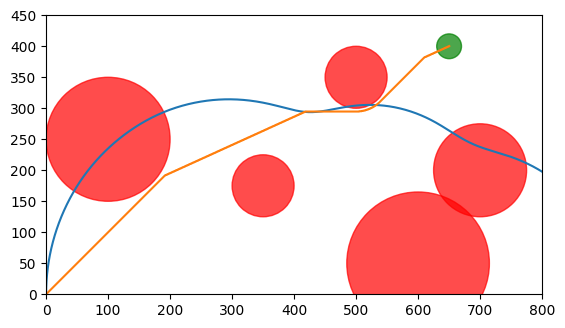

In [ ]:
#Plotting
x,y=sol[0:2]
fig, ax = plt.subplots(1)
ax.plot(x,y)
Env.PlotObjects(ax)
ax.set_aspect('equal',adjustable='box')
ax.set_ylim(floor,cieling)
ax.set_xlim(0,XLim)
path_x = [p[0] for p in path]
path_y = [p[1] for p in path]
ax.plot(path_x,path_y)
plt.show()